# NN Pytorch

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.decomposition import PCA


## DATASET LOADING / SAVING

In [25]:
X = pd.read_csv('/home/singhaniatanay18/X_resampled.csv')
Y = pd.read_csv('./Y_resampled.csv',header=None)

In [26]:
print(X.shape)
print(Y.shape)

(7477003, 35)
(7477003, 1)


In [13]:
catenc = pd.factorize(Y.iloc[:,0])

In [14]:
Y2 = pd.DataFrame(data=catenc[0])
print(Y2.shape)

(7477003, 1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5009592, 35)
(5009592, 1)
(2467411, 35)
(2467411, 1)


In [16]:
Xtr_np = np.array(X_train)
Ytr_np = np.array(y_train)
print(Ytr_np.shape)
print(Xtr_np.shape)
print(type(Ytr_np[0][0]))

(5009592, 1)
(5009592, 35)
<class 'numpy.int64'>


In [19]:
train = torch.utils.data.TensorDataset(torch.Tensor(Xtr_np), torch.Tensor(Ytr_np))
torch.save(train,'train.pt')

In [20]:
Xte_np = np.array(X_test)
Yte_np = np.array(y_test)
test = torch.utils.data.TensorDataset(torch.Tensor(Xte_np), torch.Tensor(Yte_np))
torch.save(test,'test.pt')

## LOAD DATASET

In [2]:
tr = torch.load('./train.pt')
te = torch.load('./test.pt')

RuntimeError: unexpected EOF, expected 657584042 more bytes. The file might be corrupted.

In [3]:
train_loader = torch.utils.data.DataLoader(tr, batch_size = 1024, shuffle = True)

In [4]:
test_loader = torch.utils.data.DataLoader(te, batch_size = 1024, shuffle = True)

In [5]:
print(len(train_loader))
print(len(test_loader))

4893
2410


In [10]:
print(tr[0])

(tensor([8.0000e+01, 5.0110e+06, 4.0000e+00, 6.5696e+02, 6.5696e+02, 0.0000e+00,
        1.6424e+02, 3.2848e+02, 1.9761e+03, 5.2546e+02, 1.5965e+00, 7.1585e+05,
        1.8912e+06, 5.0048e+06, 2.1727e+01, 2.0653e+03, 1.5030e+03, 3.6911e+02,
        5.0109e+06, 1.6703e+06, 2.8881e+06, 5.0052e+06, 9.2000e+01, 9.2000e+01,
        7.9825e-01, 0.0000e+00, 2.9256e+02, 4.4680e+05, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 8.1920e+03, 2.2098e+02, 2.0000e+01, 0.0000e+00]), tensor([14.]))


In [4]:
scaler = StandardScaler()
# Fit on training set only.
sc2 = QuantileTransformer()
sc2.fit(tr.tensors[0])
scaler.fit(tr.tensors[0])
# Apply transform to both the training set and the test set.
train_scaled_quantile = sc2.transform(tr.tensors[0])
test_scaled_quantile = sc2.transform(te.tensors[0])
train_scaled = scaler.transform(tr.tensors[0])
test__scaled = scaler.transform(te.tensors[0])

In [5]:
print(train_scaled.shape)
print(train_scaled_quantile.shape)
print(test_scaled_quantile.shape)
print(test__scaled.shape)

(5009592, 35)
(5009592, 35)
(2467411, 35)
(2467411, 35)


## PCA

In [6]:
# Make an instance of the Model
pca = PCA(.95)

In [7]:
pca.fit(train_scaled_quantile)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
pca.n_components_

8

In [9]:
train_PCA = pca.transform(train_scaled_quantile)
test_PCA = pca.transform(test_scaled_quantile)
print(type(train_PCA))

<class 'numpy.ndarray'>


In [10]:
train2 = torch.utils.data.TensorDataset(torch.Tensor(train_PCA), torch.Tensor(tr.tensors[1]))
torch.save(train2,'train_PCA_quantile.pt')
test2 = torch.utils.data.TensorDataset(torch.Tensor(test_PCA), torch.Tensor(te.tensors[1]))
torch.save(test2,'test_PCA_quantile.pt')

In [18]:
tr2 = torch.load('train_PCA_quantile.pt')
te2 = torch.load('test_PCA_quantile.pt')
train_loader = torch.utils.data.DataLoader(tr2, batch_size = 2048, shuffle = True)
test_loader = torch.utils.data.DataLoader(te2, batch_size = 1024, shuffle = True)

In [19]:
print(len(train_loader))
print(len(test_loader))

2447
2410


## NEURAL NET

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, 30)
        self.fc7 = nn.Linear(30, 28)
        self.fc8 = nn.Linear(28, 28)
        self.fc9 = nn.Linear(28, 28)
        self.fc10 = nn.Linear(28, 15)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
        return F.log_softmax(x, dim=1)

In [14]:
print(torch.cuda.is_available())
device = torch.device('cuda:0')
print(device)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on GPU')
else:
    device = torch.device('cpu')
    print('running on GPU')

True
cuda:0
running on GPU


In [15]:
net = Net().to(device)
print(net)

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=30, bias=True)
  (fc7): Linear(in_features=30, out_features=28, bias=True)
  (fc8): Linear(in_features=28, out_features=28, bias=True)
  (fc9): Linear(in_features=28, out_features=28, bias=True)
  (fc10): Linear(in_features=28, out_features=15, bias=True)
)


In [16]:
#loss_function = nn.NLLLoss()
loss_function = nn.MultiLabelMarginLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
from torchviz import make_dot

In [28]:
for data in train_loader:
    xx,yy = data
    break

In [20]:
xx,yy = xx[0],yy[0]

In [29]:
xx = xx.to(device)
yy = yy.to(device)

In [30]:
y = net(xx.view(xx.size(0),-1))

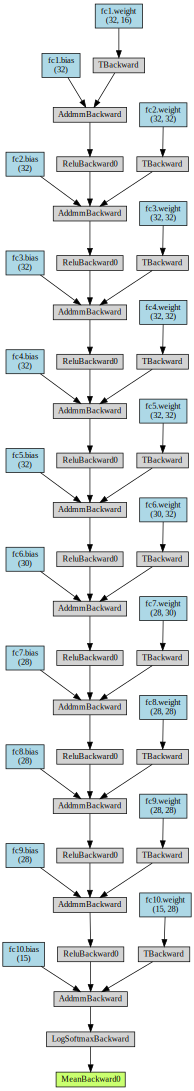

In [31]:
make_dot(y.mean(),params=dict(net.named_parameters()))

## TRAIN

In [25]:
total = len(train_loader)
loss_list = []
for epoch in range(30):
    i =0# 3 full passes over the data
    outer = tqdm(total=0, desc='Epoch', position=0)
    for data in train_loader:
        xx,yy = data# X is the batch of features, y is the batch of targets.
        #print(xx.size(1))
        xx = xx.to(device)
        yy = yy.to(device)
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(xx.view(xx.size(0), -1))  # pass in the reshaped batch (recall they are 28x28 atm)
        #print('output nikla')
        #print(output.size(1))
        #print(yy.size(1))
        yy = yy.squeeze(1)
        loss = F.nll_loss(output, yy.long())  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
        loss_list.append(float(loss))
        outer.set_description_str(f'Epoch : {epoch} ; Curr itr : {i}/{total} ; Loss : {loss}')
        i +=1
    print(f'Epoch : {epoch} ; Curr itr : {i}/{total} ; Loss : {loss} ')

Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.026958966627717018: 0it [01:15, ?it/s]

Epoch : 0 ; Curr itr : 2447/2447 ; Loss : 0.026958966627717018 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.02938605099916458: 0it [01:15, ?it/s] 

Epoch : 1 ; Curr itr : 2447/2447 ; Loss : 0.02938605099916458 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.013021253980696201: 0it [01:16, ?it/s]

Epoch : 2 ; Curr itr : 2447/2447 ; Loss : 0.013021253980696201 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.009087873622775078: 0it [01:17, ?it/s]

Epoch : 3 ; Curr itr : 2447/2447 ; Loss : 0.009087873622775078 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.024397756904363632: 0it [01:16, ?it/s]

Epoch : 4 ; Curr itr : 2447/2447 ; Loss : 0.024397756904363632 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.012914312072098255: 0it [01:16, ?it/s]

Epoch : 5 ; Curr itr : 2447/2447 ; Loss : 0.012914312072098255 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.030406033620238304: 0it [01:18, ?it/s]

Epoch : 6 ; Curr itr : 2447/2447 ; Loss : 0.030406033620238304 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.07506664842367172: 0it [01:16, ?it/s] 

Epoch : 7 ; Curr itr : 2447/2447 ; Loss : 0.07506664842367172 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.02077832631766796: 0it [01:16, ?it/s] 

Epoch : 8 ; Curr itr : 2447/2447 ; Loss : 0.02077832631766796 


Epoch: 0it [00:00, ?it/s]46/2447 ; Loss : 0.0631062388420105: 0it [01:16, ?it/s]  

Epoch : 9 ; Curr itr : 2447/2447 ; Loss : 0.0631062388420105 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.03921324387192726: 0it [01:18, ?it/s] 

Epoch : 10 ; Curr itr : 2447/2447 ; Loss : 0.03921324387192726 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.0077460408210754395: 0it [01:16, ?it/s]

Epoch : 11 ; Curr itr : 2447/2447 ; Loss : 0.0077460408210754395 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.06409978121519089: 0it [01:17, ?it/s] 

Epoch : 12 ; Curr itr : 2447/2447 ; Loss : 0.06409978121519089 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.02657974511384964: 0it [01:18, ?it/s] 

Epoch : 13 ; Curr itr : 2447/2447 ; Loss : 0.02657974511384964 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.014065832830965519: 0it [01:17, ?it/s]

Epoch : 14 ; Curr itr : 2447/2447 ; Loss : 0.014065832830965519 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.025334002450108528: 0it [01:18, ?it/s]

Epoch : 15 ; Curr itr : 2447/2447 ; Loss : 0.025334002450108528 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.019389716908335686: 0it [01:19, ?it/s]

Epoch : 16 ; Curr itr : 2447/2447 ; Loss : 0.019389716908335686 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.029678072780370712: 0it [01:16, ?it/s]

Epoch : 17 ; Curr itr : 2447/2447 ; Loss : 0.029678072780370712 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.025325942784547806: 0it [01:16, ?it/s]

Epoch : 18 ; Curr itr : 2447/2447 ; Loss : 0.025325942784547806 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.014720333740115166: 0it [01:16, ?it/s]

Epoch : 19 ; Curr itr : 2447/2447 ; Loss : 0.014720333740115166 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.026278847828507423: 0it [01:17, ?it/s]

Epoch : 20 ; Curr itr : 2447/2447 ; Loss : 0.026278847828507423 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.04885561391711235: 0it [01:16, ?it/s] 

Epoch : 21 ; Curr itr : 2447/2447 ; Loss : 0.04885561391711235 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.08461152762174606: 0it [01:16, ?it/s] 

Epoch : 22 ; Curr itr : 2447/2447 ; Loss : 0.08461152762174606 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.030334480106830597: 0it [01:17, ?it/s]

Epoch : 23 ; Curr itr : 2447/2447 ; Loss : 0.030334480106830597 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.024036355316638947: 0it [01:16, ?it/s]

Epoch : 24 ; Curr itr : 2447/2447 ; Loss : 0.024036355316638947 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.0969695970416069: 0it [01:15, ?it/s]  

Epoch : 25 ; Curr itr : 2447/2447 ; Loss : 0.0969695970416069 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.016707032918930054: 0it [01:18, ?it/s]

Epoch : 26 ; Curr itr : 2447/2447 ; Loss : 0.016707032918930054 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.03761334344744682: 0it [01:16, ?it/s] 

Epoch : 27 ; Curr itr : 2447/2447 ; Loss : 0.03761334344744682 


Epoch: 0it [00:00, ?it/s]446/2447 ; Loss : 0.03192101791501045: 0it [01:16, ?it/s] 

Epoch : 28 ; Curr itr : 2447/2447 ; Loss : 0.03192101791501045 


Epoch : 29 ; Curr itr : 2446/2447 ; Loss : 0.056883759796619415: 0it [01:16, ?it/s]

Epoch : 29 ; Curr itr : 2447/2447 ; Loss : 0.056883759796619415 


In [23]:
torch.save(net,'MultiLabelMarginLoss3_PCA_quantile')

In [9]:
net = torch.load('MultiLabelMarginLoss3_PCA_100')

In [27]:
correct = 0
total = 0
itr = 0
y_true = []
y_pred = []
with torch.no_grad():
    ooo = tqdm(total=len(test_loader), desc='Itr', position=0)
    for data in test_loader:
        xx, y = data
        xx = xx.to(device)
        y = y.to(device)
        output = net(xx.view(xx.size(0), -1))
        y = y.squeeze(1)
        y = y.long()
        #print(output)
        
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
#             y_pred.append(torch.argmax(i))
#             y_true.append(y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        ooo.set_description_str(f'Itr :{itr}/{len(test_loader)}')
        itr+=1

print("Accuracy: ", (correct/total, 3))
print('Length of Y_true : ',len(y_true))
print('Length of Y_pred : ',len(y_pred))

Itr :2409/2410:   0%|          | 0/2410 [03:53<?, ?it/s]

Accuracy:  (0.9831929094909604, 3)
Length of Y_true :  0
Length of Y_pred :  0


In [14]:
lossList = pd.DataFrame(loss_list)

In [16]:
lossList.to_csv('LOSS.csv')

In [16]:
print(0.9863776241574671)

0.9863776241574671


In [11]:
import sklearn.metrics as skm
import matplotlib.pyplot as plt

In [21]:
print(type(y_true[0].item()))

<class 'int'>


In [13]:
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i].item()
    y_true[i] = y_true[i].item()

In [36]:
cm = skm.confusion_matrix(y_true, y_pred)
print(cm)
print(skm.classification_report(y_true,y_pred))

[[818096      0     12     24     47    169      0      1      8      8
       9     60      7      0   1964]
 [  1399      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [    17      0  75846      0      0      0      0      1      0      0
       0      0      0      0      0]
 [     9      0      0  13039     12      0      0      0      0      0
       0     19      0      0      0]
 [    36      0      0      8   3239      0      0      0      0      0
       2     29      0      0      0]
 [   179      0      0      0      0 185302    151      0      0      0
       0      0      0      0    294]
 [     0      0      0      0      0     37    534      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0 226829      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0  55280      0
    7111      0      0      0      0]
 [     9  

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    820405
           1       0.00      0.00      0.00      1399
           2       1.00      1.00      1.00     75864
           3       0.99      1.00      1.00     13079
           4       0.98      0.98      0.98      3314
           5       1.00      1.00      1.00    185926
           6       0.78      0.94      0.85       571
           7       1.00      1.00      1.00    226829
           8       0.72      0.89      0.79     62391
           9       1.00      1.00      1.00     60475
          10       0.77      0.52      0.62     45059
          11       1.00      1.00      1.00    151092
          12       0.76      0.17      0.27       132
          13       1.00      0.54      0.70        54
          14       1.00      1.00      1.00    820821

    accuracy                           0.99   2467411
   macro avg       0.87      0.80      0.81   2467411
weighted avg       0.99   

In [25]:
losss = pd.read_csv('LOSS.csv')

In [33]:
graphval = losss.iloc[:,1]

In [36]:
import matplotlib.pyplot as plt

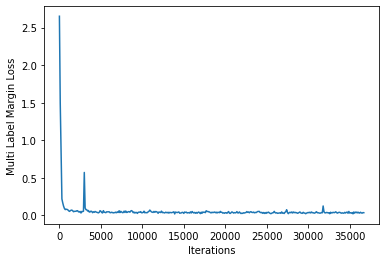

In [47]:
plt.plot(graphval[::100])
plt.xlabel('Iterations')
plt.ylabel('Multi Label Margin Loss')
plt.savefig('lossgraph.png')

In [85]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",verticalalignment = "center_baseline",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [60]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = [i+1 for i in range(15)],
                  columns = [i+1 for i in range(15)])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)?

SyntaxError: invalid syntax (<ipython-input-60-4787475a3bb3>, line 5)

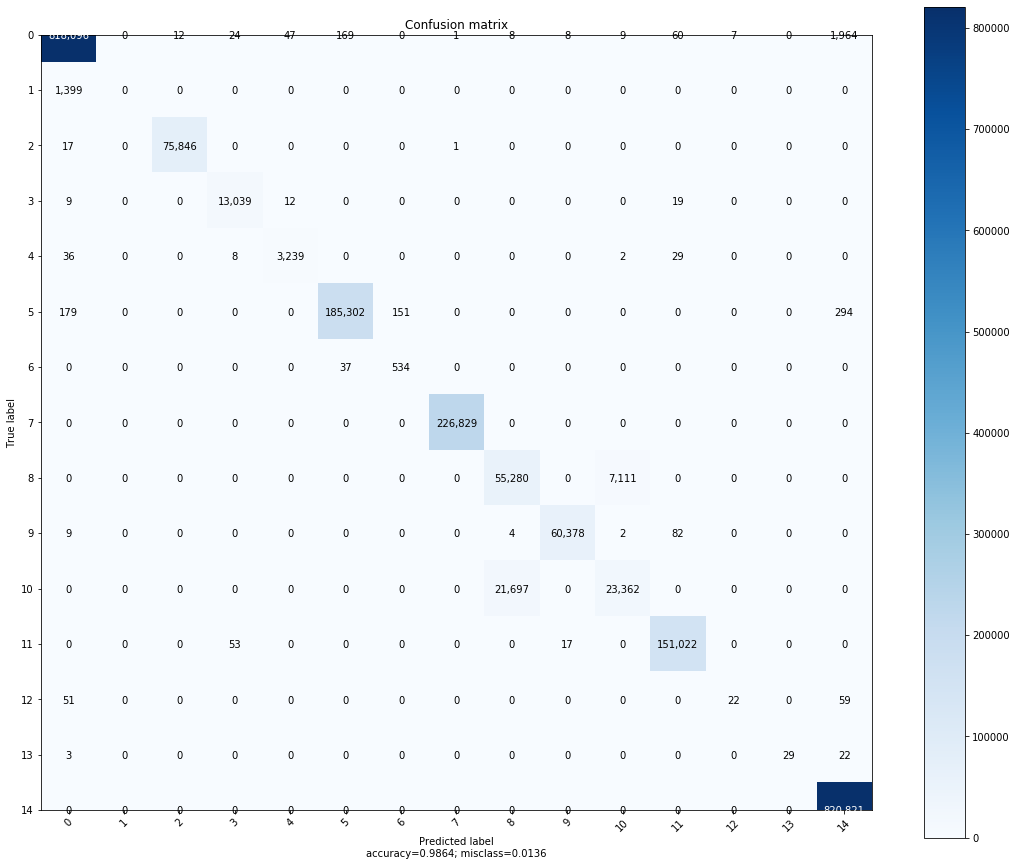

In [86]:
plot_confusion_matrix(cm,[i for i in range(15)],normalize=False)

AttributeError: 'AxesImage' object has no property 'annot'

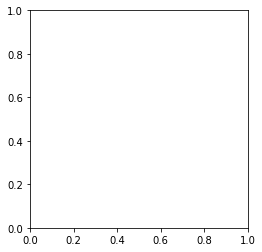